In [14]:
import torch
import torch.nn as nn
from tqdm import tqdm
from torchtext.vocab import build_vocab_from_iterator
from torch.utils.data import DataLoader, random_split
from utils import tokenizer, Collator
from data import AGNewsDataset
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [16]:
agnews = AGNewsDataset(text="Description")
agnews_train, agnews_valid = random_split(agnews, lengths=[20000, 100_000])

In [17]:
import re

def clean_text(text: str):
    text = text.lower().strip()
    text = re.sub(r"([.!?])", r" \1", text)
    text = re.sub(r"[^a-zA-Z!?]+", r" ", text)
    return text

def yield_tokens(dataset, tokenizer=tokenizer):
    for row in tqdm(dataset):
        yield tokenizer(clean_text(row[-1]))

In [18]:
PAD_IDX, UNK_IDX, BOS_IDX, EOS_IDX = 0, 1, 2, 3
special_symbols = ["<pad>", "<unk>", "<bos>", "<eos>"]
vocab = build_vocab_from_iterator(
    yield_tokens(agnews_train), min_freq=1, specials=special_symbols, special_first=True)
vocab.set_default_index(UNK_IDX)

100%|██████████| 20000/20000 [00:02<00:00, 9189.22it/s]


In [19]:
collate = Collator(vocab=vocab)

In [20]:
train_loader = DataLoader(agnews_train, batch_size=24, shuffle=True, collate_fn=collate)

In [23]:
import torch.optim as optim
from model import RVAE
from trainer import RVAETrainer

rvae = RVAE(
    vocab_size=len(vocab),
    embedding_size=512,
    hidden_size=768,
    latent_size=128,
    with_att=True,
    device=device,
).to(device)
optimizer = optim.Adam(rvae.parameters(), lr=8e-4)
criterion = nn.CrossEntropyLoss(ignore_index=0, reduction="mean")
trainer = RVAETrainer(
    model=rvae,
    optimizer=optimizer,
    verbose_period=1,
    device=device,
    params={"loc": 3e3, "scale": 6e2},
)

In [ ]:
trainer.fit(7, train_loader)

In [35]:
torch.cuda.empty_cache()

In [36]:
rvae.eval()

RVAE(
  (embedding): Embedding(29599, 256, padding_idx=0, max_norm=1)
  (encoder): EncoderRNN(
    (embedding): Embedding(29599, 256, padding_idx=0, max_norm=1)
    (gru): GRU(256, 128, batch_first=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (decoder): AttnDecoderRNN(
    (embedding): Embedding(29599, 256, padding_idx=0, max_norm=1)
    (attention): BahdanauAttention(
      (Wa): Linear(in_features=128, out_features=128, bias=True)
      (Ua): Linear(in_features=128, out_features=128, bias=True)
      (Va): Linear(in_features=128, out_features=1, bias=True)
    )
    (gru): GRU(384, 128, batch_first=True)
    (out): Linear(in_features=128, out_features=29599, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (hidden2mu): Linear(in_features=128, out_features=32, bias=True)
  (hidden2logvar): Linear(in_features=128, out_features=32, bias=True)
  (latent2hidden): Linear(in_features=32, out_features=128, bias=True)
)

In [37]:
_, encoder_inputs = next(iter(train_loader))
encoder_inputs = encoder_inputs.to(device)
logits, _, _ = rvae(encoder_inputs)


In [38]:
for i in range(5):
    print(" ".join(vocab.lookup_tokens(encoder_inputs[i].tolist())))

the it industry has two horses in the u s presidential race this year <eos> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
chip eberhart writes in post magazine dvd studio pro version is truly a world class dvd authoring application this outstanding version of dvd studio pro adds enough bells whistles and real world functionality to make even a seasoned dvd author take notice and say wow ! sep <eos> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
taiwan president chen shui bian said sunday a controversial arms deal was part of the government s attempts to deter any attempt by rival china to invade the island <eos> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
nac b

In [39]:
for i in range(5):
    print(" ".join(vocab.lookup_tokens(logits.argmax(dim=-1)[i].tolist())))

the it industry has two promises in the u s presidential race this year holiday the the <eos> the the <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos>
dow kreme writes in post magazine dvd studio pro version is nt a world takeover inc officer network safety version strategy of dvd and the president move to company to released and <eos> to make with a improve program company take <eos> and say <eos> may to and <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos>
taiwan president chen shui bian said sunday a controversial arms deal was part of the government s comments to answer any attempt by rival china to address the island <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos>
eden poured won t appeal 

In [44]:
dataloader = DataLoader(agnews_train, batch_size=32, shuffle=False, collate_fn=collate)

In [45]:
torch.cuda.empty_cache()

In [46]:
import numpy as np

label_list = []
mu_list = []
with torch.no_grad():
    for label, encoder_inputs in tqdm(dataloader):
        encoder_inputs = encoder_inputs.to(device)
        _, mu, logvar = rvae(encoder_inputs)
        label_list.append(label)
        mu_list.append(mu.squeeze())

mus = torch.cat(mu_list, dim=0)
labels = []
for elem in label_list:
    labels += elem
labels = np.array(labels)

100%|██████████| 625/625 [00:24<00:00, 25.24it/s]


In [49]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, init='pca')
mus_tsne = tsne.fit_transform(mus.cpu().numpy())

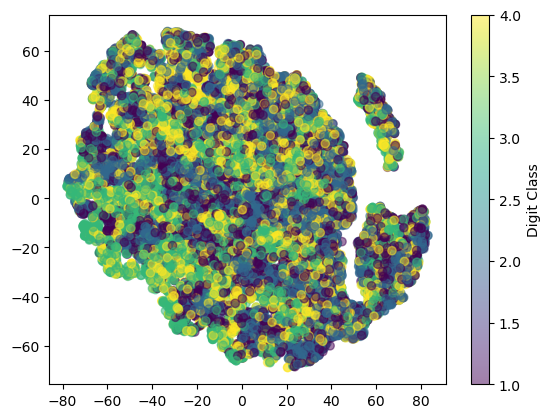

In [50]:
import matplotlib.pyplot as plt

plt.scatter(mus_tsne[:, 0], mus_tsne[:, 1], alpha=0.5, 
            c=labels)
plt.colorbar(label='Digit Class')

In [11]:
train_loader = DataLoader(agnews_train, batch_size=24, shuffle=True, collate_fn=collate)

In [12]:
import torch.optim as optim
from model import RVAE
from trainer import RVAETrainer

rvae = RVAE(
    vocab_size=len(vocab),
    embedding_size=256,
    hidden_size=128,
    latent_size=32,
    with_att=False,
    device=device,
    num_layers=2
).to(device)
optimizer = optim.Adam(rvae.parameters(), lr=8e-4)
criterion = nn.CrossEntropyLoss(ignore_index=0, reduction="mean")
trainer = RVAETrainer(
    model=rvae,
    optimizer=optimizer,
    verbose_period=1,
    device=device,
    params={"loc": 3e3, "scale": 6e2},
)

In [14]:
trainer.fit(7, train_loader)

epoch 6: 100%|██████████| 834/834 [01:06<00:00, 12.47batch/s, kl_loss=0.186, reconstr_loss=4.03]


In [29]:
torch.cuda.empty_cache()

In [16]:
rvae.eval()
_, encoder_inputs = next(iter(train_loader))
encoder_inputs = encoder_inputs.to(device)
logits, _, _ = rvae(encoder_inputs)


In [17]:
for i in range(5):
    print(" ".join(vocab.lookup_tokens(encoder_inputs[i].tolist())))

there is growing fear among united nations officials that secretary general kofi annan may have lost the confidence of the organisation s most powerful constituent the united states <eos> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
fc barcelona players samuel eto o center from cameroon and ronaldinho second left from brazil argue with getafe players vivar dorade left from spain and mariano pernia right from argentina during their spanish league soccer match in getafe spain <eos> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
pc world cofounder reflects on company s first ten years at web conference <eos> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>

In [18]:
for i in range(5):
    print(" ".join(vocab.lookup_tokens(logits.argmax(dim=-1)[i].tolist())))

a is the to of the nations and to have of kofi annan s be to a first of the world of role important political the country states <eos> to <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos>
chelsea barcelona captain samuel eto o fils and the and ronaldinho spain seeded points the s after roma goals and dorade left in the s the pernia left in the <eos> the second league <eos> club <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos>
pc world number and on the s new half year <eos> the search <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos>
ap the least behest of the louis historic to the kerry s he was to a new bank in the united t

In [21]:
z = torch.randn(1, 2, 32).to(device)
# z = mu[0] + logvar[0].exp().sqrt() * z
hidden = rvae.latent2hidden(z).permute((1, 0, 2)).contiguous()

generation_frame = torch.Tensor(1, 128)

logits, _, _ = rvae.decoder(generation_frame, hidden)

" ".join(vocab.lookup_tokens(
    logits.argmax(dim=-1)[0].tolist()
))


'new york the world s top team has been a new record in the world s first round of the year and the world s top team is expected to be the first time <eos> <eos> <eos> <eos> from the world <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos>'

In [22]:
dataloader = DataLoader(agnews_train, batch_size=32, shuffle=False, collate_fn=collate)

In [28]:
import numpy as np
torch.cuda.empty_cache()

label_list = []
mu_list = []
with torch.no_grad():
    for label, encoder_inputs in tqdm(dataloader):
        encoder_inputs = encoder_inputs.to(device)
        _, mu, logvar = rvae(encoder_inputs)
        label_list.append(label)
        mu_list.append(mu.permute((1, 0, 2)).contiguous().view(-1, 64))

mus = torch.cat(mu_list, dim=0)
labels = []
for elem in label_list:
    labels += elem
labels = np.array(labels)

100%|██████████| 625/625 [00:16<00:00, 38.37it/s]


In [30]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, init='pca')
mus_tsne = tsne.fit_transform(mus.cpu().numpy())

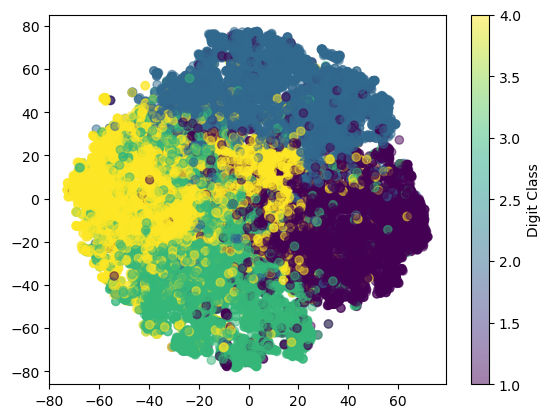

In [31]:
import matplotlib.pyplot as plt

plt.scatter(mus_tsne[:, 0], mus_tsne[:, 1], alpha=0.5, 
            c=labels)
plt.colorbar(label='Digit Class')

# 1-4: world, sport, business, sci/tech